# Practical Assignment — Graph Neural Networks

Uncomment lines in Colab

In [ ]:
#!pip install node2vec dgl
#!pip install dgl

In [1]:
import dgl
from dgl.data import CoraGraphDataset
from dgl.nn import GraphConv, GATConv, SAGEConv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
from node2vec import Node2Vec
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Task 1. The baseline — Node2Vec (2 points)

We will use Node2Vec as a baseline for comparison with other models. Let us download the Cora dataset, that consists of scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [2]:
data = CoraGraphDataset()

Extracting file to /Users/ruaihm4/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


Convert into Networkx and numpy types

In [3]:
G = dgl.to_networkx(data[0])
labels = data[0].ndata['label'].numpy()
train_mask = data[0].ndata['train_mask'].numpy()
test_mask = data[0].ndata['test_mask'].numpy()

Here we compute probabilities and generate random walks

In [4]:
n2v = Node2Vec(G, dimensions=16, walk_length=20, 
               num_walks=10, p=1, q=1.5)

Generating walks (CPU: 1):   0%|          | 0/10 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


Here we fit our model

In [5]:
model = n2v.fit(window=10, min_count=1)

Write a function `n2v_train_test` that takes a `model`, graph `G`, np.arrays `labels`, `train_mask` and `test_mask`. The function returns np.arrays with embeddings `X_train`, `X_test` and np.arrays with labels `y_train`, `y_test`. The embeddings are in the `model.wv attribute`.

In [12]:
def n2v_train_test(model, G, labels, train_mask, test_mask):
    emb = np.array([model.wv.get_vector(str(node)) for node in G.nodes])
    X_train = emb[train_mask]
    X_test = emb[test_mask]
    y_train = labels[train_mask]
    y_test = labels[test_mask]
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = n2v_train_test(model, G, labels, train_mask, test_mask)
assert X_train.shape == (140, 16)
assert X_test.shape == (1000, 16)
assert y_train.shape == (140,)
assert y_test.shape == (1000,)

Write a function `logreg` that takes `X_train`, `X_test`, `y_train`, `y_test` and returns predictions from LogisticRegression model.

In [14]:
def logreg(X_train, X_test, y_train, y_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

In [15]:
y_pred = logreg(X_train, X_test, y_train, y_test)
score = balanced_accuracy_score(y_test, y_pred)
assert score > 0.55
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.63


### PyTorch quick start

Here are the basics of PyTourch. If you are familiar with this material, skip it. 

First, let us generate a toy dataset.

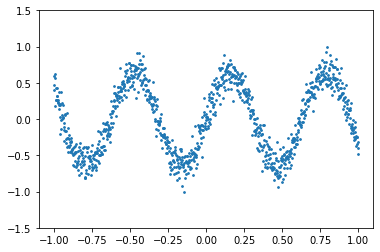

In [16]:
N = 1000
X = np.linspace(-10, 10, N)
np.random.seed(0)
y = np.sin(X) + np.random.normal(0, 0.2, N)
X = minmax_scale(X, (-1, 1))
y = minmax_scale(y, (-1, 1))
plt.scatter(X, y, s=3)
plt.ylim(-1.5, 1.5);

Convert np.arrays into tensors via `torch.FloatTensor` (float type) or `torch.LongTensor` (int type).

In [17]:
X_tensor = torch.FloatTensor(X[:, None])
y_tensor = torch.FloatTensor(y[:, None])

Here is a simple shallow perceptron with layer sizes $1 \to 64 \to 64 \to 1$.

In [18]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))

Define loss function and optimizer.

In [19]:
MSE = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.005)

The train loop constists of: computing loss, grad, making a step to the optimum.

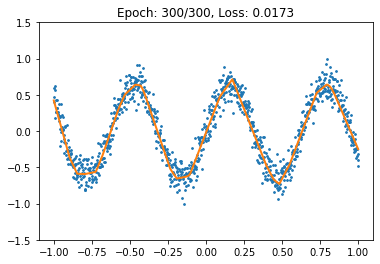

In [20]:
n_epochs = 300
for i in range(n_epochs):
    
    y_pred = model.forward(X_tensor)
    loss = MSE(y_pred, y_tensor)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    plt.scatter(X, y, s=3)
    plt.plot(X, y_pred.detach().numpy(), linewidth=2, c='tab:orange')
    plt.title('Epoch: {}/{}, Loss: {:.4f}'.format(i+1, n_epochs, loss.item()))
    plt.ylim(-1.5, 1.5)
    plt.show()
    clear_output(wait=True)

### Task 2. Spectral graph convolutional network (3 points)

Graph convolution mathematically is defined as follows:

$$h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{(l)}W^{(l)})$$

where $\mathcal{N}(i)$ is the set of neighbors of node $i$,$c_{ij}$ is the product of the square root of node degrees (i.e.,  $c_{ij} = \sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}$), and $\sigma$ is an activation function.

Build a cora dataset again, but without conversion into numpy or networkx. These are tensors by default.

In [21]:
data = CoraGraphDataset()
G = data[0]
features = G.ndata['feat']
labels = G.ndata['label']
train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


Here is an one-hot encoded feature matrix

In [22]:
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

And labels of categories.

In [23]:
labels

tensor([3, 4, 4,  ..., 3, 3, 3])

Zero in-degree nodes will lead to invalid output value. This is because no message will be passed to those nodes, the aggregation function will be appied on empty input. A common practice to avoid this is to add a self-loop for each node in the graph.

In [24]:
G = dgl.add_self_loop(G)

Complete a class `GCN`. Use `GraphConv` layers with sizes $1433 \to 16 \to 7$. Use `F.relu` activation after the first layer.

In [25]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(1433, 16)
        self.conv2 = GraphConv(16, 7)

    def forward(self, G, features):
        x = F.relu(self.conv1(G, features))
        x = self.conv2(G, x)
        return x

In [26]:
model = GCN()
assert str(model) == 'GCN(\n  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)\n  (conv2): GraphConv(in=16, out=7, normalization=both, activation=None)\n)'

For classification tasks we will use `CrossEntropy` loss. Change an optimizer if you wish.

In [27]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

Complete the train loop. To speed up calculation test loss, use `torch.no_grad()`

In [32]:
train_mask.shape

torch.Size([2708])

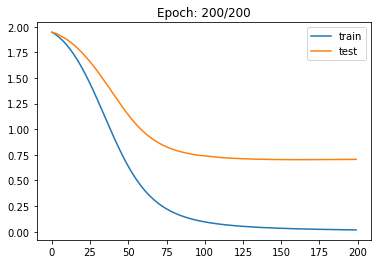

In [34]:
n_epochs = 200

log = []
for i in range(n_epochs):
    y_pred = model(G, features)
    train_loss = CrossEntropy(y_pred[train_mask], labels[train_mask])
    
    with torch.no_grad():
        test_loss = CrossEntropy(y_pred[test_mask], labels[test_mask])
    
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    
    log.append([train_loss, test_loss])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    plt.show()
    clear_output(wait=True)

In [35]:
logits = model.forward(G, features)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(labels[test_mask], y_pred)
assert score > 0.75
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.81


### Task 3. Graph attention network (3 points)

Let us apply Graph Attention Network over an input signal.

$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and node $j$:

$$\alpha_{ij}^{l} = \text{Softmax}_{i} (e_{ij}^{l})$$

$$e_{ij}^{l} = \text{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)$$

In [36]:
data = CoraGraphDataset()
G = data[0]
G = dgl.add_self_loop(G)
features = G.ndata['feat']
labels = G.ndata['label']
train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


Complete a class `GAT`. Use `GATConv` layers:
`GATConv(1433, 8, num_heads=8)` $\to$ `GATConv(8*8, 7, num_heads=1)`

In `forward` use 
* `tensor.view(-1, m * n)` to reshape `(n_features, n_heads, out_dim) -> (n_features, n_heads * out_dim)`
* `F.elu` activation after concat
* `tensor.squeeze` to decrease shape `(n_features, 1, out_dim) -> (n_features, out_dim)`

In [37]:
class GAT(nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(1433, 8, num_heads=8)
        self.conv2 = GATConv(8*8, 7, num_heads=1)

    def forward(self, G, features):
        x = F.elu(self.conv1(G, features).view(-1, 8 * 8))
        x = self.conv2(G, x).squeeze(1)
        return x

In [48]:
model = GAT()
assert str(model) == 'GAT(\n  (conv1): GATConv(\n    (fc): Linear(in_features=1433, out_features=64, bias=False)\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (attn_drop): Dropout(p=0.0, inplace=False)\n    (leaky_relu): LeakyReLU(negative_slope=0.2)\n  )\n  (conv2): GATConv(\n    (fc): Linear(in_features=64, out_features=7, bias=False)\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (attn_drop): Dropout(p=0.0, inplace=False)\n    (leaky_relu): LeakyReLU(negative_slope=0.2)\n  )\n)'

In [49]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), 
                       lr=0.005, weight_decay=0.001)

Complete the train loop. To speed up calculation test loss, use `torch.no_grad()`

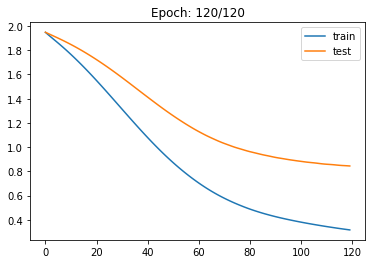

In [50]:
n_epochs = 120

log = []
for i in range(n_epochs):
    
    y_pred = model(G, features)
    train_loss = CrossEntropy(y_pred[train_mask], labels[train_mask])
    
    with torch.no_grad():
        test_loss = CrossEntropy(y_pred[test_mask], labels[test_mask])
    
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    
    log.append([train_loss, test_loss])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    plt.show()
    clear_output(wait=True)

In [51]:
logits = model.forward(G, features)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(labels[test_mask], y_pred)
assert score > 0.7
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.80


### Task 5. GraphSAGE (2 points)

Consider GraphSAGE, a representation learning technique suitable for dynamic graphs. GraphSAGE is capable of predicting embedding of a new node, without requiring a re-training procedure. To do so, GraphSAGE learns aggregator functions that can induce the embedding of a new node given its features and neighborhood. This is called inductive learning.

$$h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)$$
$$h_{i}^{(l+1)} = \sigma \left(W \cdot \text{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)$$
$$h_{i}^{(l+1)} = \mathrm{norm}(h_{i}^{l})$$

Aggregator types here can be `mean`, `gcn`, `pool`, `lstm`. Consider GraphSAGE on the Karate Club graph.

In [52]:
G = nx.karate_club_graph()

labels = [1 if i=='Mr. Hi' else 0 for i in nx.get_node_attributes(G, 'club').values()]
labels = torch.LongTensor(labels)
features = torch.FloatTensor(np.arange(0, 34)[:, None])

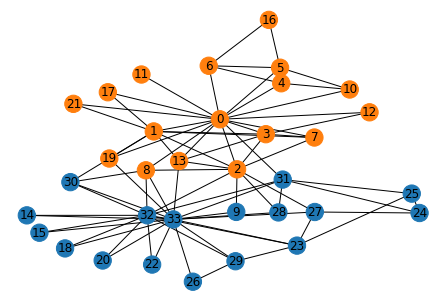

In [53]:
nx.draw_kamada_kawai(
    G, with_labels=True, 
    node_color=['tab:orange' if i==1 else 'tab:blue' for i in labels], 
    cmap=plt.cm.tab10)

Let us delete a node 31, train a model and then return it and predict its label.

In [54]:
idx = np.arange(34)
idx = idx[idx != 31]

New labels and features

In [55]:
labels = labels[idx]
features = features[idx]

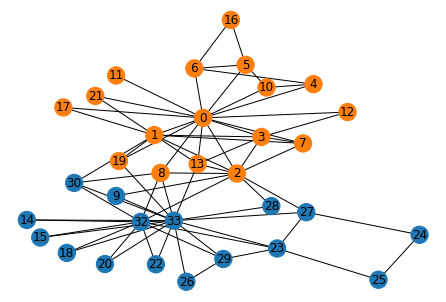

In [56]:
nx.draw_kamada_kawai(
    G.subgraph(idx), with_labels=True, 
    node_color=['tab:orange' if i==1 else 'tab:blue' for i in labels], 
    cmap=plt.cm.tab10)

Let choose test and train nodes

In [57]:
test_idx = [31, 32, 0, 11, 13, 2, 23, 29, 8]
train_idx = list(set(np.arange(33)).difference(test_idx))

Draw the graph, test nodes are gray.

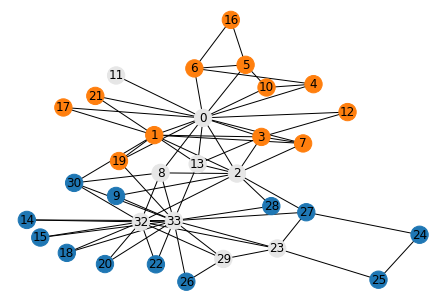

In [58]:
node_color = np.ones((33, 3))
node_color[labels == 0] = plt.cm.tab10(0)[:3]
node_color[labels == 1] = plt.cm.tab10(1)[:3]
node_color[test_idx] = (0.9, 0.9, 0.9)

nx.draw_kamada_kawai(G.subgraph(idx), with_labels=True, 
                     node_color=node_color, cmap=plt.cm.tab10)

Build a dgl graph 

In [59]:
initial_graph = dgl.from_networkx(G.subgraph(idx))
initial_graph

Graph(num_nodes=33, num_edges=144,
      ndata_schemes={}
      edata_schemes={})

Complete a class `SAGE`. Use `SAGEConv` layers with sizes $1 \to 16 \to 2$ and `mean` aggregation function. Put `F.relu` activation after the first layer.

In [60]:
class SAGE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(1, 16, "mean")
        self.conv2 = SAGEConv(16, 2, "mean")

    def forward(self, graph, inputs):
        x = F.relu(self.conv1(graph, inputs))
        x = self.conv2(graph, x)
        return x

In [65]:
model = SAGE()
assert str(model) == 'SAGE(\n  (conv1): SAGEConv(\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (fc_self): Linear(in_features=1, out_features=16, bias=True)\n    (fc_neigh): Linear(in_features=1, out_features=16, bias=True)\n  )\n  (conv2): SAGEConv(\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (fc_self): Linear(in_features=16, out_features=2, bias=True)\n    (fc_neigh): Linear(in_features=16, out_features=2, bias=True)\n  )\n)'

In [66]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.002)

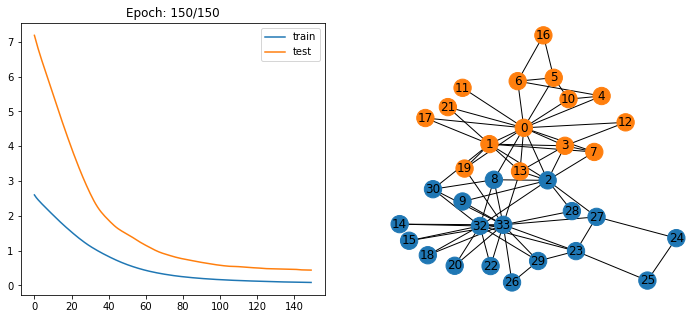

In [67]:
n_epochs = 150

log = []
for i in range(n_epochs):
    
    logits = model.forward(initial_graph, features)
    loss = CrossEntropy(logits[train_idx], labels[train_idx])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        logits = model.forward(initial_graph, features)
        test_loss = CrossEntropy(logits[test_idx], labels[test_idx])
    
    log.append([loss.item(), test_loss.item()])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    
    y_pred = torch.argmax(logits, 1)
    
    plt.subplot(1, 2, 2)
    nx.draw_kamada_kawai(
        G.subgraph(idx), with_labels=True, 
        node_color=['tab:orange' if i==1 else 'tab:blue' for i in y_pred], 
        cmap=plt.cm.tab10)
    
    
    plt.show()
    clear_output(wait=True)


Let us check that prediction for the node 31 is correct

In [68]:
graph = dgl.from_networkx(G)
labels = [1 if i=='Mr. Hi' else 0 for i in nx.get_node_attributes(G, 'club').values()]
labels = torch.LongTensor(labels)
features = torch.FloatTensor(np.arange(0, 34)[:, None])
predictions = torch.argmax(model(graph, features), 1)
assert predictions[31] == labels[31]